# Processing Sequences Using RNNs and CNNs

Recurrent neural networks can work on sequences of arbitrary length, making them very useful for time series data or text processing.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import tensorflow.keras as keras

%matplotlib inline
np.random.seed(0)
sns.set_style('whitegrid')

## Recurrent neurons and layers

A recurrent neuron looks just like a normal feedforward neuron except it also has connections pointing backwards.
At each *time step t* (or *frame*), a recurrent neuron receives the inputs $\textbf{x}_{(t)}$ as well as its own output from a previous time step, $\textbf{y}_{(t-1)}$.
Thus, each neuron has two sets of weights, $\textbf{w}_x$ and $\textbf{w}_y$.
These inputs and weights get multiplied together and passed to an activation function just like for a feedforward network.
The following function is for a layer of recurrent neurons at a time frame $t$ where $\phi$ is the activation function and $b$ is the bias.

$$
\textbf{y}_{(t)} = \phi(\textbf{W}_x^T \textbf{x}_{(t)} + \textbf{W}_y^T \textbf{y}_{(t-1)} + b)
$$

Generally, the initial value of $\textbf{y}$ at $t=0$ is set to 0.
It is common to see a recurrent neuron displayed across the time axis - this is called *unrolling the network through time*.

### Memory cells

A recurrent neuron has a form of memory because its output is a function of the data at the current and previous time step.
A part of a neural network that preserves some state acrosss time steps is called a *memory cell* (or just a *cell*).

### Input and output sequences

There are various types of RNNs based on their input and output types:

* *sequence-to-sequences*: An RNN that takes a sequence of inputs and produces a sequence of outputs.
* *sequence-to-vector*: A network that takes a sequence and only the final output is used.
* *vector-to-sequence*: The same input vector is passed in repetitively and an output sequence is collected.
* *encoder-decoder*: A sequence-to-vector network (encoder) followed by a vector-to-sequence network (decoder).

## Training RNNs

The trick to training an RNN is to unroll the network through time and use regular backpropagation.
This is called *backpropagation through time* (BPTT).
Thankfully, this hassle is handled by TF Keras.

## Forecasting a time series

A time series can be *univariate* or *multivariate* with a single or multiple feature at each time step, respectively.
Time series analyses are often either forecasting, predicting future values, or imputing, filling in missing data.

For simplicity, we will use a mock time series data set generated by the `generate_time_series()` function.
It returns data of the shape $[batch\ size,\ time\ steps,\ dimensionality]$.
The *dimensionality* refers to if the data is univariate or multivariate.

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time-offsets1) * (freq1 * 10 + 10))   # wave 1
    series += 0.2 * np.sin((time-offsets2) * (freq2 * 20 + 20))  # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # noise
    return series[..., np.newaxis].astype(np.float32)

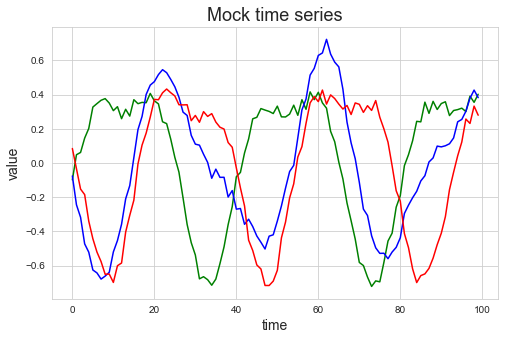

In [3]:
np.random.seed(0)
x = generate_time_series(3, 100)

fig = plt.figure(figsize=(8, 5))
plt.plot(x[0, :], 'g-')
plt.plot(x[1, :], 'b-')
plt.plot(x[2, :], 'r-')
plt.xlabel('time', fontsize=14)
plt.ylabel('value', fontsize=14)
plt.title('Mock time series', fontsize=18)
plt.show()

Now we can create some mock data and split it into training, validation, and test sets.
This mock data will have 10,000 times series, each 50 steps long.

In [4]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

### Baseline metrics

A baseline metric will help us recognize if our model is actually worth creating.
It provides some indication of how hard the data is to predict.

A simple metric called *naive forecasting* is to simply predict the previous value.
In this case, is has a MSE of 0.021.

In [5]:
naive_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, naive_pred))

0.021185566

Another approach is to use a very simple neural network.
Here we can use a single dense neuron; the output is thus a linear combination of the inputs.
This model can make predictions on the validation data with a MSE of 0.004.

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Nadam(),
    loss=keras.losses.MeanSquaredError()
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    verbose=0
)

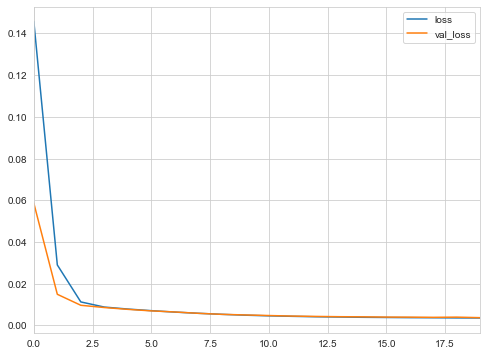

In [7]:
pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.show()

In [8]:
y_pred = model.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.0036995797

### Implementing a simple RNN

The simplest RNN we can create is just a single neuron.
Thus, there are a total of 3 parameters: a weight for the input, a weight for the previous output, and a bias term.
This is far less than the 51 parameters for the linear model above (1 parameter per input feature and a bias term).
Thus, it is not surprising to see that this simple model cannot outperform a higher-dimensional linear model.

Note that the input shape is `[None, 1]`.
This is because the RNN can take any length of input (number of time steps).

In [9]:
simple_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

simple_rnn.compile(
    optimizer=keras.optimizers.Nadam(),
    loss=keras.losses.MeanSquaredError()
)

history = simple_rnn.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    verbose=0
)

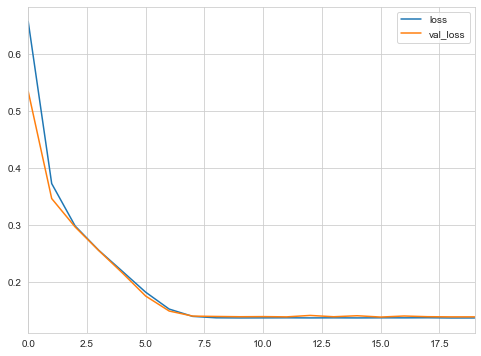

In [10]:
pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.show()

In [11]:
y_pred = simple_rnn.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.13912646

### Deep RNNs

Keras makes it easy to make a deep RNN by just stacking `SimpleRNN` layers.
Note that it is necessary to explicitly tell each layer to output the entire sequence so that the next layer doesn't just receive the final output of the previous one.

We can use another `SimpleRNN` for the final layer, but it is often preferrable to use a single `Dense` neuron.
One reason is that there is only one hidden variable for the single recurrent neuron whereas the normal neuron has a weight for each input.
Also, the recurrent neuron uses the tanh activation function, limiting the output to between -1 and 1.

In [12]:
deep_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=False),
    keras.layers.Dense(1)
])

deep_rnn.compile(
    optimizer=keras.optimizers.Nadam(),
    loss=keras.losses.MeanSquaredError()
)

history = deep_rnn.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    verbose=0
)

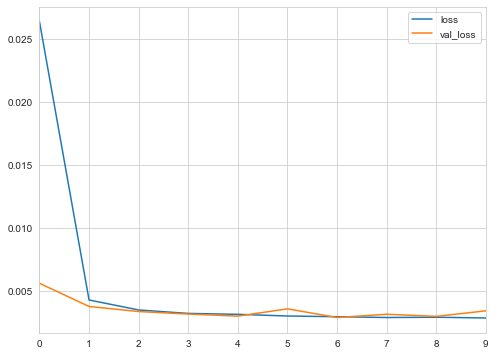

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.show()

In [14]:
y_pred = deep_rnn.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.003383608

### Forecasting several time steps ahead

So far, we have only predicted the value at the next time step, but we could have predicted the value after 10 additional steps by changing how we split the mock data into X and y datasets.
But what if we wanted to predict all of the next 10 steps.

One way to do this is to use the model trained above to predict the next step, then add that output to the input and have it predict the next step after that, and so on.

In [30]:
np.random.seed(2)
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

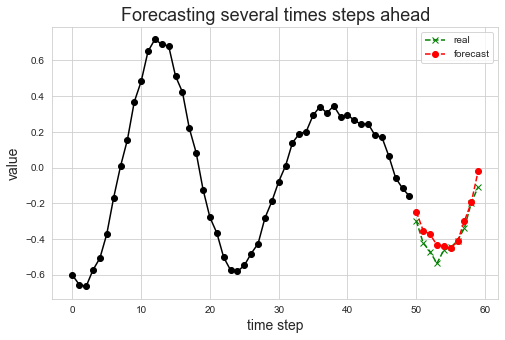

In [31]:
fig = plt.figure(figsize=(8, 5))
plt.plot(range(X_new.shape[1]), 
         X_new[0, :, 0], 
         'k-o')
plt.plot(range(X_new.shape[1], X_new.shape[1] + Y_new.shape[1]), 
         Y_new[0, :, 0], 
         'g--x', label='real')
plt.plot(range(X_new.shape[1], X_new.shape[1] + Y_pred.shape[1]), 
         Y_pred[0, :, 0], 
         'r--o', label='forecast')
plt.xlabel('time step', fontsize=14)
plt.ylabel('value', fontsize=14)
plt.title('Forecasting several times steps ahead', fontsize=18)
plt.legend(loc='best')
plt.show()

Another option is to train the RNN to predict all 10 next values at once.
We will still use a sequence to vector model, but there will be 10 output values instead of 1.
We must first, however, change the targets to be vectors containing the last 10 values.

In [17]:
np.random.seed(0)
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

The only change to the model is that the final dense layer must have 10 neurons.

In [18]:
deep_rnn_10steps = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

deep_rnn_10steps.compile(
    optimizer=keras.optimizers.Nadam(),
    loss=keras.losses.MeanSquaredError()
)

history = deep_rnn_10steps.fit(
    X_train, Y_train,
    epochs=20,
    validation_data=(X_valid, Y_valid),
    verbose=0
)

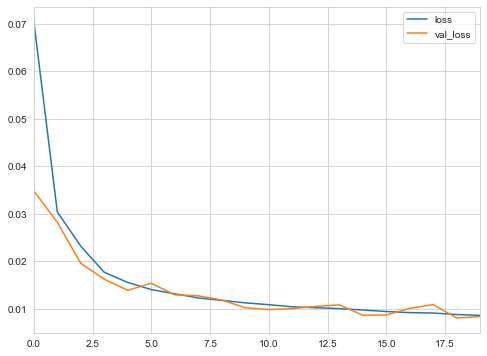

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.show()

In [20]:
Y_pred = deep_rnn_10steps.predict(X_valid)
np.mean(keras.losses.mean_squared_error(Y_valid, Y_pred))

0.008342622

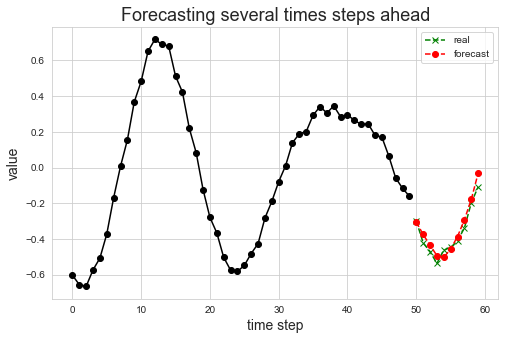

In [32]:
Y_pred = deep_rnn_10steps.predict(X_new)

fig = plt.figure(figsize=(8, 5))
plt.plot(range(X_new.shape[1]), 
         X_new[0, :, 0], 
         'k-o')
plt.plot(range(X_new.shape[1], X_new.shape[1] + Y_new.shape[1]), 
         Y_new[0, :, 0], 
         'g--x', label='real')
plt.plot(range(X_new.shape[1], X_new.shape[1] + Y_pred.shape[1]), 
         Y_pred[0, :], 
         'r--o', label='forecast')
plt.xlabel('time step', fontsize=14)
plt.ylabel('value', fontsize=14)
plt.title('Forecasting several times steps ahead', fontsize=18)
plt.legend(loc='best')
plt.show()

We can do still better by having the model constantly trying to predict the next 10 steps from the very beginning, not just the very end.
This basically increases the amount of training data for the model.

**To-Do**: finish up this section, tomorrow.